In [1]:
# !pip3 install opencv-python
# !pip3 install 'git+https://github.com/facebookresearch/segment-anything.git'
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

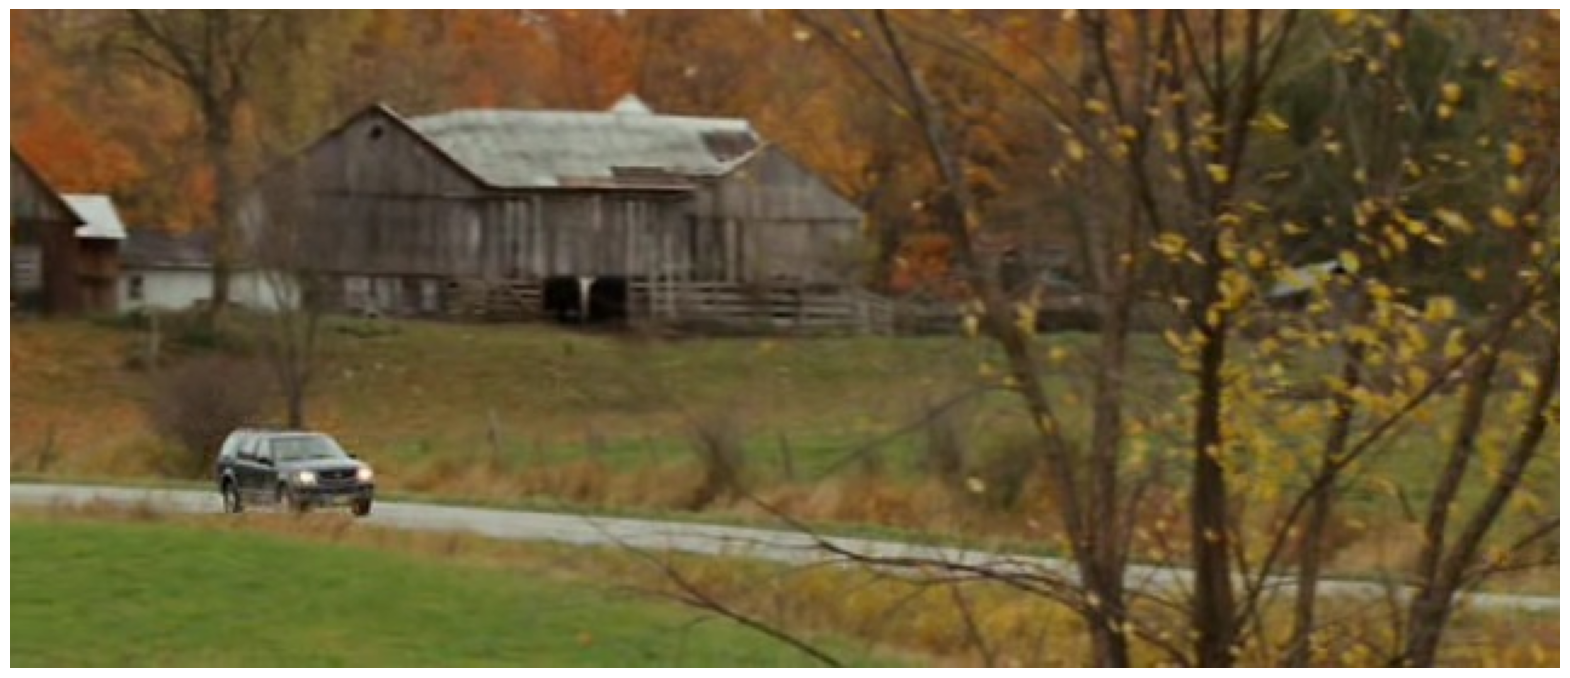

In [4]:
image = cv2.imread('/projects/academic/rohini/m44/git-prjs/3DVision/Mach/data/00000117.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

from copy import  deepcopy
test_img = deepcopy(image)

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.98,
    crop_n_layers=0,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=600,  # Requires open-cv to run post-processing
)

In [6]:
image[10,10,0]

99

In [7]:
masks = mask_generator.generate(image)

In [8]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 1822,
  'bbox': [85.0, 173.0, 65.0, 35.0],
  'predicted_iou': 1.0062971115112305,
  'point_coords': [[90.0, 182.75]],
  'stability_score': 0.9830878376960754,
  'crop_box': [0, 0, 640, 272]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 16197,
  'bbox': [0.0, 208.0

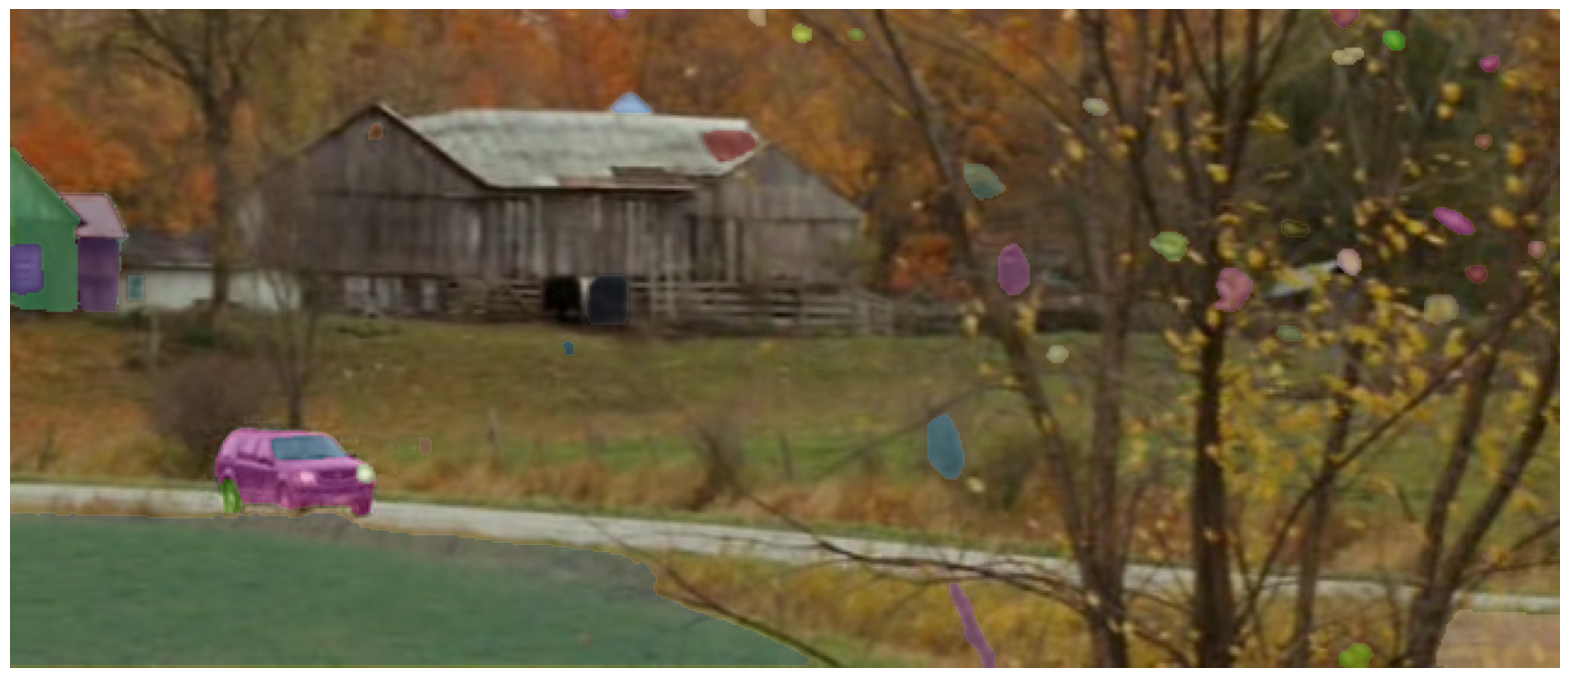

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [10]:
def make_square(image):
    h, w, _ = image.shape
    desired_size = max(h,w)
    if w > h:
        padding_y = max(0, (desired_size - h) // 2)

        # Create a new square canvas filled with zeros (black)
        square_image = np.zeros((desired_size, desired_size, 3), dtype=np.uint8)

        # Place the original image in the center
        square_image[padding_y:padding_y + h, :, :] = image
    else:
        padding_x = max(0, (desired_size - w) // 2)

        # Create a new square canvas filled with zeros (black)
        square_image = np.zeros((desired_size, desired_size, 3), dtype=np.uint8)

        # Place the original image in the center
        square_image[:, padding_x:padding_x+w, :] = image

    return square_image

In [11]:
# masks = list of dictionaries with keys 'bbox' which has mask in XYWH format
# crop each mask and store it in a list
cropped_masks = []
for mask in masks:
    x, y, w, h = mask['bbox']
    
    if (w*h < 200):
        continue
    
    maxlen = max(w,h)
    
    # ymin = int(y)
    # ymax = int(ymin + h)
    # xmin = int(x)
    # xmax = int(xmin + w)
    
    centroid_x = x + w/2
    centroid_y = y + h/2
    
    ymin = min(max(0,int(centroid_y - maxlen)), image.shape[0])
    ymax = min(max(0,int(centroid_y + maxlen)), image.shape[0])
    xmin = min(max(0,int(centroid_x - maxlen)), image.shape[0])
    xmax = min(max(0,int(centroid_x + maxlen)), image.shape[0])
    
    # ymin = min(max(0,int(centroid_y - 112)), image.shape[0])
    # ymax = min(max(0,int(centroid_y + 112)), image.shape[0])
    # xmin = min(max(0,int(centroid_x - 112)), image.shape[0])
    # xmax = min(max(0,int(centroid_x + 112)), image.shape[0])

    # check if nothing got cropped
    if (ymin + ymax == h) and (xmin + xmax == w):
        cropped_masks.append(test_img[ymin:ymax, xmin:xmax, :])
    # if some part of the image did get cropped, pad it
    else:
        cropped_masks.append(make_square(test_img[ymin:ymax, xmin:xmax, :]))

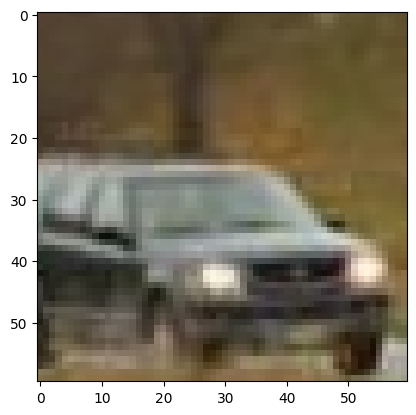

In [12]:
plt.imshow(cropped_masks[8])
plt.show()

In [13]:
# infer_img = make_square(cropped_masks[0])
# infer_img = infer_img.transpose(2,0,1)
# infer_img.shape
# infer_img = cropped_masks[0]
cropped_masks[0].shape

(130, 130, 3)

In [14]:
from main_resnet import infer_single_image

preds = []

for infer_img in cropped_masks:
    preds.append(infer_single_image(infer_img))
# preds.append(infer_single_image(cropped_masks[0]))

Device:  cuda
torch.Size([3, 130, 130])
torch.Size([3, 272, 272])
torch.Size([3, 96, 96])
torch.Size([3, 134, 134])
torch.Size([3, 134, 134])
torch.Size([3, 63, 63])
torch.Size([3, 52, 52])
torch.Size([3, 42, 42])
torch.Size([3, 60, 60])
torch.Size([3, 38, 38])
torch.Size([3, 40, 40])
torch.Size([3, 34, 34])
torch.Size([3, 58, 58])
torch.Size([3, 52, 52])
torch.Size([3, 52, 52])
torch.Size([3, 32, 32])
torch.Size([3, 40, 40])


In [17]:
pred_arr = np.array(preds)
np.where(pred_arr > 0)[0]

array([8])

In [18]:
pred_arr

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])